In [15]:
import datasets
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
import matplotlib.pyplot as plt
from tqdm import trange
import random

In [2]:
data = datasets.load_dataset('yelp_review_full')

Reusing dataset yelp_review_full (/home/ubuntu/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43)


In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [13]:
data['test'][-4]

{'label': 4,
 'text': 'Great ambience. Great drinks. Great food. I love this place!'}

In [9]:
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
model = AutoModelForMaskedLM.from_pretrained('roberta-large')

In [30]:
embs = []
labels = []
for i in trange(1):
    item = data['train'][i]
    input_str = f'It was {tokenizer.mask_token}. {item["text"]}'
    inputs = tokenizer(input_str, return_tensors='pt', truncation=True)
    outputs = model(**inputs)
    assert(inputs['input_ids'][0, 3] == tokenizer.mask_token_id)
    emb = outputs.logits[0, 3]
    embs.append(emb.detach().numpy())
    labels.append(item['label'])


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


In [34]:
random.seed(1234)
in_context_examples = {}
for i in range(50):
    item = data['train'][i]
    if len(item['text'].split()) < 50:
        in_context_examples[item['label']] = item['text']
verbalizers = ['terrible', 'bad', 'okay', 'good', 'great']
in_context_examples = [f'It was {verbalizers[label]}. {in_context_examples[label]}' for label in in_context_examples]
in_context_examples = ' / '.join(in_context_examples)
in_context_examples

"It was great. Tonya is super sweet and the front desk people are very helpful / It was okay. Good beer selection. Understaffed for a light Monday night crowd, it wasn't her fault she was the only server. But it took about an hour to get our sandwiches. Mine was one of the best reubens I've ever had. / It was bad. Average run of the mill store.  Associates are young teens and they really don't know where anything is.  Luckily I am able to get around to find everything.  Found my puppy treats and moved on. / It was terrible. Terrible. Preordered my tires and when I arrived they couldn't find the order anywhere. Once we got through that process I waited over 2 hours for them to be put on... I was originally told it would take 30 mins. Slow, over priced, I'll go elsewhere next time. / It was good. Great breakfast, good price. You might have to stand outside in line though, so I don't really recommend winter time to go. lol. Very friendly service, interesting coffee mugs. They have great d

In [35]:
embs_test = []
labels_test = []
for i in trange(200):
    item = data['test'][i]
    input_str = f'It was {tokenizer.mask_token}. {item["text"]} / {in_context_examples}'
    inputs = tokenizer(input_str, return_tensors='pt', truncation=True)
    outputs = model(**inputs)
    assert(inputs['input_ids'][0, 3] == tokenizer.mask_token_id)
    emb = outputs.logits[0, 3]
    embs_test.append(emb.detach().numpy())
    labels_test.append(item['label'])


  4%|▎         | 7/200 [00:06<02:47,  1.15it/s]

In [28]:
idxs = [tokenizer.vocab['Ġ' + word] for word in ['terrible', 'bad', 'okay', 'good', 'great']]
preds_test = [emb[idxs].argmax() for emb in embs_test]
assert(len(preds_test) == len(embs_test) == len(labels_test))
acc = (np.array(preds_test) == np.array(labels_test)).mean()
print(acc)
print(preds_test)

0.445
[0, 0, 0, 0, 0, 2, 3, 4, 4, 3, 4, 4, 0, 2, 4, 4, 4, 0, 4, 0, 4, 2, 0, 0, 3, 0, 1, 4, 4, 1, 3, 3, 1, 4, 0, 0, 4, 4, 0, 4, 0, 1, 3, 0, 4, 0, 0, 0, 3, 0, 4, 3, 4, 0, 3, 4, 0, 1, 4, 0, 4, 1, 0, 4, 4, 4, 0, 4, 0, 2, 4, 0, 4, 4, 4, 4, 0, 4, 2, 4, 0, 0, 2, 4, 2, 0, 4, 4, 0, 4, 1, 4, 4, 4, 3, 3, 1, 4, 0, 4, 0, 4, 4, 2, 0, 0, 4, 3, 1, 4, 2, 4, 0, 4, 0, 0, 4, 2, 3, 4, 4, 3, 2, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 1, 2, 4, 1, 1, 2, 0, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 4, 0, 0, 0, 3, 2, 2, 4, 0, 4, 0, 4, 3, 3, 4, 3, 3, 0, 4, 0, 0, 3, 0, 4, 4, 4, 4, 3, 0, 0, 0, 1, 0, 4, 1, 0, 3, 4, 4, 2, 0, 2, 2, 0, 4]


In [48]:
embs = np.array(embs)
labels = np.array(labels)
embs_test = np.array(embs_test)
labels_test = np.array(labels_test)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embs)


In [90]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# clf = MLPClassifier(random_state=1, max_iter=300)
# clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
# clf = svm.LinearSVC()
clf.fit(embs, labels)
preds = clf.predict(embs)
acc = (preds == labels).mean()
print(acc)

0.64


In [91]:
preds_test = clf.predict(embs_test)
acc = (preds_test == labels_test).mean()
print(preds_test)
print(acc)

[1 1 1 1 1 1 4 4 4 4 4 4 1 1 4 4 4 1 4 1 1 1 1 1 4 1 1 4 4 1 4 4 1 4 1 1 4
 4 1 4 1 1 4 1 1 1 1 1 1 1 4 4 4 1 4 4 4 4 4 1 4 1 1 4 4 4 1 4 1 4 4 1 4 4
 4 2 1 4 1 4 1 1 1 4 1 1 4 4 1 4 1 4 4 4 4 1 4 4 1 4 1 1 4 4 1 1 1 4 1 4 1
 4 1 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 1 2 4 4 1 1 4 1 4 4 1 1 1 1
 1 1 1 4 4 4 1 4 1 1 1 4 1 4 1 1 4 1 4 4 4 4 4 4 1 2 1 1 1 1 4 4 4 4 4 2 4
 1 1 1 4 4 4 2 1 4 1 1 1 2 1 4]
0.32


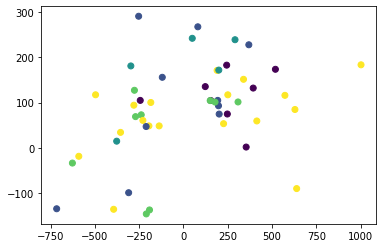

In [69]:
x, y = zip(*pca.transform(embs))
plt.scatter(x, y, c=labels)

In [85]:
idxs = [tokenizer.vocab['Ġ' + word] for word in ['terrible', 'bad', 'okay', 'good', 'great']]
preds_test = [emb[idxs].argmax() for emb in embs_test]
acc = (preds_test == labels_test).mean()
print(acc)
print(preds_test)

0.425
[0, 0, 0, 0, 0, 4, 3, 4, 4, 2, 4, 4, 0, 2, 4, 4, 4, 0, 4, 0, 4, 2, 0, 0, 3, 0, 1, 4, 4, 0, 3, 3, 1, 4, 0, 0, 4, 4, 1, 4, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 4, 2, 4, 0, 3, 4, 1, 0, 4, 0, 4, 0, 0, 4, 4, 4, 0, 4, 0, 2, 4, 0, 4, 4, 4, 4, 0, 4, 2, 4, 1, 0, 1, 4, 2, 0, 4, 4, 4, 4, 1, 3, 3, 2, 3, 3, 1, 4, 1, 4, 0, 4, 4, 2, 0, 0, 1, 3, 1, 4, 1, 4, 0, 4, 0, 0, 4, 2, 3, 4, 3, 3, 2, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 2, 4, 0, 2, 3, 0, 4, 4, 4, 0, 0, 0, 0, 3, 3, 3, 3, 4, 0, 4, 0, 0, 0, 3, 2, 2, 3, 0, 4, 3, 1, 3, 3, 4, 3, 3, 0, 4, 0, 0, 3, 0, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 4, 1, 4, 3, 4, 4, 2, 0, 2, 2, 0, 4]


(array([44.,  0., 53.,  0.,  0., 36.,  0., 38.,  0., 29.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

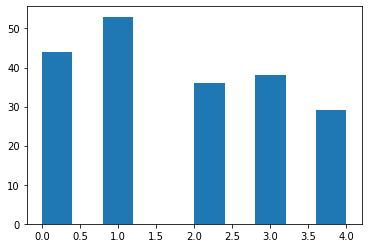

In [64]:
plt.hist(labels_test)

In [ ]:
No-context: 42.5
With context (5): 44.5